In [1]:
# Import Libraries
import math
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Define Solar Plant Data File
sunlab_faro = pd.read_csv('Sunlab_Faro_Cleaned_mjs.csv')

# Ensure Datetime is in datetime format
sunlab_faro['Datetime'] = pd.to_datetime(sunlab_faro['Datetime'])

# Sort the data by datetime for readability
sunlab_faro = sunlab_faro.sort_values(by='Datetime')

In [3]:
sunlab_faro.head()

,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm]
0,2014-01-01 07:41:00,14.6,0.19527,2.850946,9.4,0.00,0.000000,0.000000,9.7,9.7,7.131149,0.751824,0.700000,275.33384,0.0
1,2014-01-01 07:42:00,23.1,0.07250,1.674750,9.4,18.30,0.130512,2.388366,9.7,9.7,7.040442,0.781930,0.666667,278.50306,0.0
2,2014-01-01 07:43:00,23.1,0.07500,1.732500,9.4,22.35,0.052500,1.173375,9.7,9.7,6.594407,0.813929,0.616667,284.66712,0.0
3,2014-01-01 07:44:00,23.1,0.07750,1.790250,9.5,24.35,0.052500,1.278375,9.7,9.7,7.358729,0.849919,0.666667,278.66666,0.0
4,2014-01-01 07:45:00,22.2,0.08250,1.831500,9.5,25.25,0.052500,1.325625,9.7,9.7,7.470711,0.886891,0.633333,272.66636,0.0


In [4]:
sunlab_faro.tail()

,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm]
833673,2017-12-31 17:14:00,0.0,0.0,0.0,17.6,0.0,0.0,0.0,18.2,16.600000,4.253332,0.836134,5.283334,298.33362,0.0
833674,2017-12-31 17:15:00,0.0,0.0,0.0,17.6,0.0,0.0,0.0,18.2,16.600000,4.628277,0.824518,4.583334,293.33710,0.0
833675,2017-12-31 17:16:00,0.0,0.0,0.0,17.5,0.0,0.0,0.0,18.1,16.600000,7.650642,0.810895,3.533333,286.99006,0.0
833676,2017-12-31 17:17:00,0.0,0.0,0.0,17.4,0.0,0.0,0.0,18.1,16.600000,8.252296,0.779220,3.016667,291.67706,0.0
833677,2017-12-31 17:18:00,0.0,0.0,0.0,17.4,0.0,0.0,0.0,18.0,16.550002,6.739828,0.752964,5.100000,295.66644,0.0


In [5]:
# view summary statistics
sunlab_faro.describe(include='all')

,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm]
count,833678,833678.000000,833678.000000,833678.000000,833678.000000,833678.000000,833678.000000,833678.000000,833678.000000,8.336780e+05,833678.000000,833678.000000,8.336780e+05,833678.000000,833678.000000
mean,2015-10-26 18:04:17.327049728,27.118184,3.504649,98.448497,28.468207,25.951535,3.553634,97.045584,30.343410,-5.376799e+03,449.180629,27.217776,-5.395166e+03,197.837774,0.000291
min,2014-01-01 07:41:00,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.300000,-1.500000e+09,0.732156,0.500453,-1.500000e+09,0.000000,0.000000
25%,2014-10-05 08:13:15,27.050000,0.977500,27.208500,21.300000,26.700000,0.962500,23.528000,22.300000,1.660000e+01,153.678990,9.670922,1.650000e+00,122.493330,0.000000
50%,2015-07-27 08:09:30,27.900000,3.312500,95.159188,28.600000,27.350000,3.265000,92.109875,30.500000,2.100000e+01,422.699340,24.338738,2.516667e+00,217.503060,0.000000
75%,2016-12-27 12:32:45,28.950000,5.900000,166.168750,35.600000,28.000000,6.147500,167.909625,38.300000,2.523334e+01,720.995820,43.190892,3.416667e+00,267.246715,0.000000
max,2017-12-31 17:18:00,36.900000,10.237500,307.636875,58.600000,36.550000,10.237500,310.708125,62.000000,3.830000e+01,1484.379800,85.515376,1.228333e+01,359.999200,2.040000
std,NaN,4.187117,2.575776,71.903439,8.939499,4.748999,2.653285,72.668901,9.829492,2.845458e+06,319.896252,19.578594,2.845458e+06,86.841576,0.010850


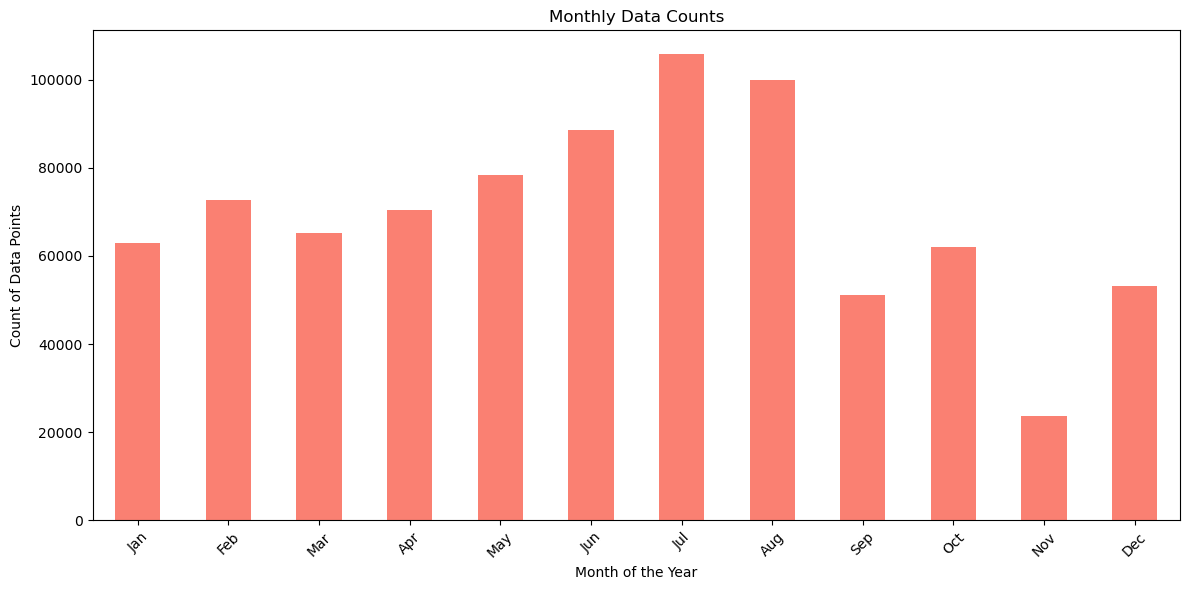

In [6]:
# Extract month from datetime
sunlab_faro['Solar_Month'] = sunlab_faro['Datetime'].dt.month

# group data by month for plotting
monthly_data_count = sunlab_faro.groupby('Solar_Month').size()

# Plot bar chart
plt.figure(figsize=(12,6))
monthly_data_count.plot(kind='bar', color='salmon')
plt.title('Monthly Data Counts')
plt.xlabel('Month of the Year')
plt.ylabel('Count of Data Points')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()

<Axes: >

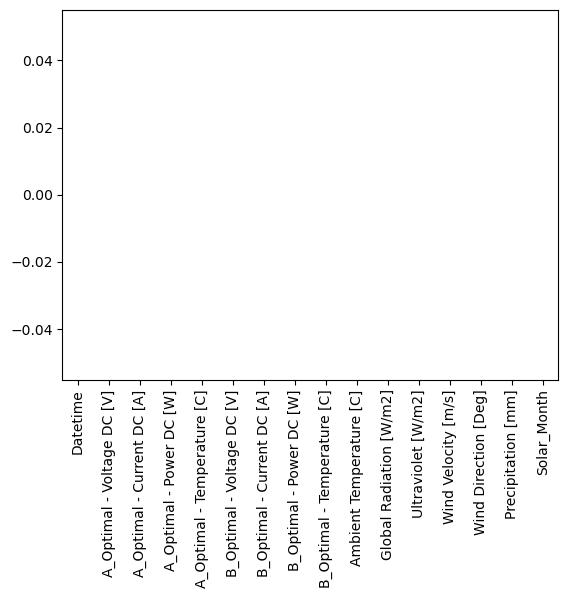

In [7]:
# check for NA values
sunlab_faro.isna().sum().plot.bar()

In [8]:
# check basic file info
print(sunlab_faro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833678 entries, 0 to 833677
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Datetime                     833678 non-null  datetime64[ns]
 1   A_Optimal - Voltage DC [V]   833678 non-null  float64       
 2   A_Optimal - Current DC [A]   833678 non-null  float64       
 3   A_Optimal - Power DC [W]     833678 non-null  float64       
 4   A_Optimal - Temperature [C]  833678 non-null  float64       
 5   B_Optimal - Voltage DC [V]   833678 non-null  float64       
 6   B_Optimal - Current DC [A]   833678 non-null  float64       
 7   B_Optimal - Power DC [W]     833678 non-null  float64       
 8   B_Optimal - Temperature [C]  833678 non-null  float64       
 9   Ambient Temperature [C]      833678 non-null  float64       
 10  Global Radiation [W/m2]      833678 non-null  float64       
 11  Ultraviolet [W/m2]        

In [9]:
# Define Solar Plant Data File
sunlab_faro = pd.read_csv('Sunlab_Faro_Cleaned_mjs.csv')

# Ensure Datetime is in datetime format
sunlab_faro['Datetime'] = pd.to_datetime(sunlab_faro['Datetime'])

# Sort the data by datetime for readability
sunlab_faro = sunlab_faro.sort_values(by='Datetime')

In [10]:
# Extract day from datetime
sunlab_faro['Solar_Day'] = sunlab_faro['Datetime'].dt.dayofyear

# Extract year from datetime
sunlab_faro['Solar_Year'] = sunlab_faro['Datetime'].dt.year

# let's aggregate the daily power for panel A
daily_power_a = sunlab_faro.groupby(['Solar_Year', 'Solar_Day'])['A_Optimal - Power DC [W]'].sum()

In [11]:
# Create a new dataframe with daily data
daily_faro = pd.DataFrame({'Power': daily_power_a})

In [12]:
daily_faro.head()

Power
Solar_Year Solar_Day              
2014       1          35018.299321
           2          10026.893000
           3          25087.673167
           4          32204.324836
           5          60928.434669

In [13]:
# Add additional data to utilize for classification
meteo_features = sunlab_faro.groupby(['Solar_Year', 'Solar_Day']).mean()[[
    'Ambient Temperature [C]',
    'Ultraviolet [W/m2]',
    'Wind Velocity [m/s]',
    'Precipitation [mm]']]

In [14]:
# Merge into daily dataframe
daily_faro = daily_faro.join(meteo_features)

In [15]:
daily_faro.head()

Power  Ambient Temperature [C]  \
Solar_Year Solar_Day                                          
2014       1          35018.299321                14.235373   
           2          10026.893000                14.711992   
           3          25087.673167                16.413116   
           4          32204.324836                15.460041   
           5          60928.434669                24.902825   

                      Ultraviolet [W/m2]  Wind Velocity [m/s]  \
Solar_Year Solar_Day                                            
2014       1                   13.177019             1.192890   
           2                   18.534369             3.166636   
           3                   17.412619             4.958040   
           4                    8.726608             4.449393   
           5                   47.013195             2.551855   

                      Precipitation [mm]  
Solar_Year Solar_Day                      
2014       1                         0.0  
           2                         0.0  
           3                         0.0  
           4                         0.0  
           5                         0.0

In [16]:
# Rename the columns in daily_faro
daily_faro.rename(columns={
    'Power': 'Daily Power A [W]',
    'Ambient Temperature [C]': 'Avg Ambient Temp C',
    'Ultraviolet [W/m2]': 'Avg Ultraviolet W/m²',
    'Wind Velocity [m/s]': 'Avg Wind Velocity m/s',
    'Precipitation [mm]': 'Avg Percipitation mm'
}, inplace=True)

# Check the updated DataFrame
daily_faro.head()

Daily Power A [W]  Avg Ambient Temp C  \
Solar_Year Solar_Day                                          
2014       1               35018.299321           14.235373   
           2               10026.893000           14.711992   
           3               25087.673167           16.413116   
           4               32204.324836           15.460041   
           5               60928.434669           24.902825   

                      Avg Ultraviolet W/m²  Avg Wind Velocity m/s  \
Solar_Year Solar_Day                                                
2014       1                     13.177019               1.192890   
           2                     18.534369               3.166636   
           3                     17.412619               4.958040   
           4                      8.726608               4.449393   
           5                     47.013195               2.551855   

                      Avg Percipitation mm  
Solar_Year Solar_Day                        
2014       1                           0.0  
           2                           0.0  
           3                           0.0  
           4                           0.0  
           5                           0.0

In [17]:
daily_faro.tail()

Daily Power A [W]  Avg Ambient Temp C  \
Solar_Year Solar_Day                                          
2017       361             34217.506125           16.122581   
           362             41934.487250           17.102291   
           363             30872.800829           16.810970   
           364             68848.610250           17.839755   
           365             34447.776750           15.912441   

                      Avg Ultraviolet W/m²  Avg Wind Velocity m/s  \
Solar_Year Solar_Day                                                
2017       361                   11.722286               4.187578   
           362                   13.716847               3.478265   
           363                   11.343249               2.136971   
           364                   17.106737               1.658619   
           365                   13.181436               2.389197   

                      Avg Percipitation mm  
Solar_Year Solar_Day                        
2017       361                    0.000374  
           362                    0.000000  
           363                    0.000000  
           364                    0.000000  
           365                    0.000000

In [18]:
daily_file = 'Daily_Data.csv'
daily_faro.to_csv(daily_file, index=True)

In [19]:
# Define new daily grouped file
sunlab_daily = pd.read_csv('Daily_Data.csv')

In [20]:
sunlab_daily['Date'] = pd.to_datetime(sunlab_daily['Solar_Year'].astype(str) + sunlab_daily['Solar_Day'].astype(str), format='%Y%j')

In [21]:
sunlab_daily.head()

,Solar_Year,Solar_Day,Daily Power A [W],Avg Ambient Temp C,Avg Ultraviolet W/m²,Avg Wind Velocity m/s,Avg Percipitation mm,Date
0,2014,1,35018.299321,14.235373,13.177019,1.192890,0.0,2014-01-01
1,2014,2,10026.893000,14.711992,18.534369,3.166636,0.0,2014-01-02
2,2014,3,25087.673167,16.413116,17.412619,4.958040,0.0,2014-01-03
3,2014,4,32204.324836,15.460041,8.726608,4.449393,0.0,2014-01-04
4,2014,5,60928.434669,24.902825,47.013195,2.551855,0.0,2014-01-05


In [22]:
# Sort the data by date for readability
sunlab_daily = sunlab_daily.sort_values(by='Date')

In [23]:
sunlab_daily.describe()

,Solar_Year,Solar_Day,Daily Power A [W],Avg Ambient Temp C,Avg Ultraviolet W/m²,Avg Wind Velocity m/s,Avg Percipitation mm,Date
count,1135.000000,1135.000000,1135.000000,1.135000e+03,1135.000000,1.135000e+03,1135.000000,1135
mean,2015.340088,171.635242,72312.198874,-5.944397e+03,26.343499,-5.962309e+03,0.000329,2015-10-23 00:16:29.603524096
min,2014.000000,1.000000,566.607500,-2.525239e+06,3.711236,-2.525248e+06,0.000000,2014-01-01 00:00:00
25%,2014.000000,82.000000,63055.309000,1.585162e+01,18.211185,2.099123e+00,0.000000,2014-10-13 12:00:00
50%,2015.000000,174.000000,79707.792500,2.046163e+01,27.776916,2.480960e+00,0.000000,2015-07-26 00:00:00
75%,2016.000000,247.000000,88056.961685,2.465529e+01,34.336941,2.984662e+00,0.000000,2016-12-22 12:00:00
max,2017.000000,365.000000,104622.221750,3.342963e+01,50.248415,6.989304e+00,0.049377,2017-12-31 00:00:00
std,1.163346,101.785606,21809.652684,1.166541e+05,9.138065,1.166538e+05,0.002791,NaN


In [24]:
sunlab_daily.dtypes

Solar_Year                        int64
Solar_Day                         int64
Daily Power A [W]               float64
Avg Ambient Temp C              float64
Avg Ultraviolet W/m²            float64
Avg Wind Velocity m/s           float64
Avg Percipitation mm            float64
Date                     datetime64[ns]
dtype: object

In [25]:
# Feature Engineering
# interations between variables
sunlab_daily['Precip_UV'] = (sunlab_daily['Avg Percipitation mm'] * sunlab_daily['Avg Ultraviolet W/m²'])

# create lag power values
def lag_features(df, column, lags):
    for lag in lags:
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
    return df

# Add lag power to dataset
sunlab_daily = lag_features(sunlab_daily, "Daily Power A [W]", lags=[1, 3, 5])

# remove NA values
sunlab_daily = sunlab_daily.dropna()

sunlab_daily.describe()                        

,Solar_Year,Solar_Day,Daily Power A [W],Avg Ambient Temp C,Avg Ultraviolet W/m²,Avg Wind Velocity m/s,Avg Percipitation mm,Date,Precip_UV,Daily Power A [W]_lag_1,Daily Power A [W]_lag_3,Daily Power A [W]_lag_5
count,1130.000000,1130.000000,1130.000000,1.130000e+03,1130.000000,1.130000e+03,1130.000000,1130,1130.000000,1130.000000,1130.000000,1130.000000
mean,2015.346018,172.381416,72487.681502,-5.970776e+03,26.367264,-5.988705e+03,0.000330,2015-10-25 22:09:07.964601600,0.003738,72511.115712,72473.567559,72446.039417
min,2014.000000,1.000000,566.607500,-2.525239e+06,3.711236,-2.525248e+06,0.000000,2014-01-06 00:00:00,0.000000,566.607500,566.607500,566.607500
25%,2014.000000,83.000000,63268.230187,1.589320e+01,18.277213,2.098684e+00,0.000000,2014-10-17 06:00:00,0.000000,63268.230187,63231.633837,63231.633837
50%,2015.000000,174.500000,79802.073500,2.049221e+01,27.796210,2.480072e+00,0.000000,2015-07-28 12:00:00,0.000000,79802.073500,79802.073500,79802.073500
75%,2016.000000,247.000000,88059.948718,2.465757e+01,34.338121,2.983642e+00,0.000000,2016-12-23 18:00:00,0.000000,88059.948718,88059.948718,88059.948718
max,2017.000000,365.000000,104622.221750,3.342963e+01,50.248415,6.989304e+00,0.049377,2017-12-31 00:00:00,0.386416,104622.221750,104622.221750,104622.221750
std,1.162488,101.388774,21669.185985,1.169115e+05,9.107248,1.169111e+05,0.002797,NaN,0.027086,21642.313303,21685.751111,21745.006042


In [26]:
# For the LSTM model, we need to set a label column for classification
sunlab_daily['Label'] = (sunlab_daily['Daily Power A [W]'].shift(-1) > sunlab_daily['Daily Power A [W]']).astype(int)

# Drop last row
sunlab_daily = sunlab_daily[:-1]                         

In [27]:
# Set features and labels
X = sunlab_daily.drop(columns=['Label', 'Date', 'Solar_Year', 'Solar_Day'])
y = sunlab_daily['Label']

# Split data to train, validation, test (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (903, 9), (903,)
Validation set: (113, 9), (113,)
Test set: (113, 9), (113,)


In [28]:
# Init Scaler
scaler = StandardScaler()

# Scale features
features_s = ['Daily Power A [W]', 'Avg Ambient Temp C', 'Avg Ultraviolet W/m²', 'Avg Wind Velocity m/s', 'Avg Percipitation mm', 
              'Precip_UV']

# Fit scaler
X_train_scaled = scaler.fit_transform(X_train[features_s])

# Scale validation and test data
X_val_scaled = scaler.transform(X_val[features_s])
X_test_scaled = scaler.transform(X_test[features_s])

print(f"Train set (scaled): {X_train_scaled.shape}")
print(f"Validation set (scaled): {X_val_scaled.shape}")
print(f"Test set (scaled): {X_test_scaled.shape}")

Train set (scaled): (903, 6)
Validation set (scaled): (113, 6)
Test set (scaled): (113, 6)


In [29]:
# Custom Dataset class
class PowerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = PowerDataset(X_train_scaled, y_train)
val_dataset = PowerDataset(X_val_scaled, y_val)
test_dataset = PowerDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 903
Validation dataset size: 113
Test dataset size: 113


In [30]:
# Create LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_num_layers, output_size=1):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, 
                            num_layers=lstm_num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        
    def forward(self, x):
        # Reshape input for CNN
        x = x.unsqueeze(1) 
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        # Take last time step's output
        lstm_out = lstm_out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(lstm_out)
        return torch.sigmoid(out)

In [31]:
# Define parameters
input_size = X_train_scaled.shape[1] 
lstm_hidden_size = 64 
lstm_num_layers = 2
output_size = 1  

# Initialize the LSTM model
model = LSTMModel(input_size, lstm_hidden_size, lstm_num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Init to store values
train_losses = []
val_losses = []

# Training parameters
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train() 
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Compute average training loss
    train_loss /= len(train_loader)
    # Store loss for plotting
    train_losses.append(train_loss)

    # Validation step
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Compute accuracy
            predicted = (outputs > 0.5).float() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    # Store for plotting
    val_losses.append(val_loss)
    accuracy = correct / total

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}")



Epoch [1/20], Train Loss: 0.6918, Val Loss: 0.6898, Val Acc: 0.5133
Epoch [2/20], Train Loss: 0.6789, Val Loss: 0.6770, Val Acc: 0.5929
Epoch [3/20], Train Loss: 0.6583, Val Loss: 0.6633, Val Acc: 0.6106
Epoch [4/20], Train Loss: 0.6450, Val Loss: 0.6606, Val Acc: 0.5929
Epoch [5/20], Train Loss: 0.6413, Val Loss: 0.6587, Val Acc: 0.5929
Epoch [6/20], Train Loss: 0.6330, Val Loss: 0.6583, Val Acc: 0.5929
Epoch [7/20], Train Loss: 0.6329, Val Loss: 0.6558, Val Acc: 0.5929
Epoch [8/20], Train Loss: 0.6370, Val Loss: 0.6545, Val Acc: 0.6372
Epoch [9/20], Train Loss: 0.6308, Val Loss: 0.6533, Val Acc: 0.6460
Epoch [10/20], Train Loss: 0.6351, Val Loss: 0.6539, Val Acc: 0.6549
Epoch [11/20], Train Loss: 0.6317, Val Loss: 0.6532, Val Acc: 0.6726
Epoch [12/20], Train Loss: 0.6289, Val Loss: 0.6531, Val Acc: 0.6814
Epoch [13/20], Train Loss: 0.6326, Val Loss: 0.6534, Val Acc: 0.6726
Epoch [14/20], Train Loss: 0.6280, Val Loss: 0.6531, Val Acc: 0.6726
Epoch [15/20], Train Loss: 0.6282, Val Loss

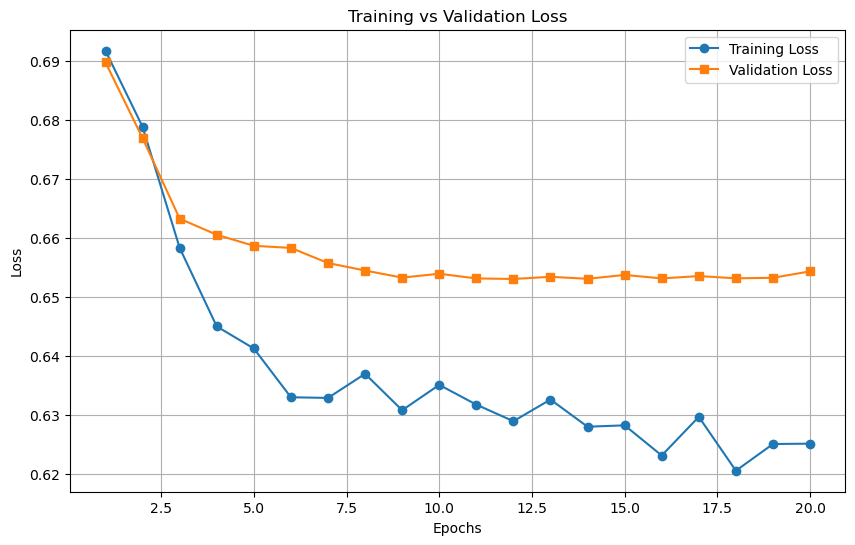

In [33]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [34]:
# Set model to evaluation mode
model.eval()

# Initialize test loss and predictions
test_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).float()

        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute average test loss
test_loss /= len(test_loader)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=1)
recall = recall_score(all_labels, all_preds, zero_division=1)
f1 = f1_score(all_labels, all_preds, zero_division=1)

# Print evaluation results
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Test Loss: 0.6201
Test Accuracy: 0.6549
Precision: 0.6739
Recall: 0.5636
F1-Score: 0.6139


In [35]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=["Power Decrease", "Power Increase"])

# Output report
print("Clasification Report")
print(report)

Clasification Report
                precision    recall  f1-score   support

Power Decrease       0.64      0.74      0.69        58
Power Increase       0.67      0.56      0.61        55

      accuracy                           0.65       113
     macro avg       0.66      0.65      0.65       113
  weighted avg       0.66      0.65      0.65       113



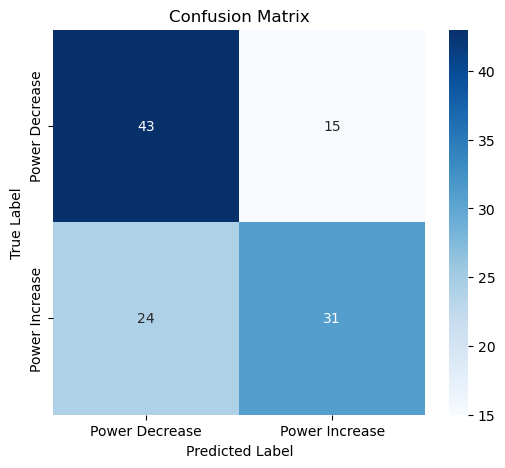

In [36]:
# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Power Decrease", "Power Increase"],
            yticklabels=["Power Decrease", "Power Increase"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [78]:
# Define Solar Plant Data File
sunlab_minute = pd.read_csv('Sunlab_Faro_Cleaned.csv')

# Ensure Datetime is in datetime format
sunlab_minute['Datetime'] = pd.to_datetime(sunlab_minute['Datetime'])

# Sort the data by datetime for readability
sunlab_minute = sunlab_minute.sort_values(by='Datetime')

In [79]:
sunlab_minute.head()

,Datetime,A_Vertical - Voltage DC [V],A_Vertical - Current DC [A],A_Vertical - Power DC [W],A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Horizontal - Voltage DC [V],A_Horizontal - Current DC [A],A_Horizontal - Power DC [W],...,Solar_Month,Ambient Temperature [ÂºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Meteo_Month
0,2017-01-20 07:52:00+00:00,19.25,0.0750,1.44375,21.60,0.1075,2.322000,18.80,0.0650,1.222,...,1,4.900000,7.267174,6.914082,1.353073,3.600000,331.65972,0.0,1013.7668,1
1,2017-01-20 07:53:00+00:00,19.25,0.0850,1.63625,32.15,0.0450,1.446750,18.80,0.0725,1.363,...,1,4.983333,8.119104,7.055244,1.416638,3.900000,330.66696,0.0,1013.7668,1
2,2017-01-20 07:54:00+00:00,19.20,0.1175,2.25600,32.75,0.0450,1.473750,18.75,0.0800,1.500,...,1,5.000000,8.641460,8.173192,1.483865,3.550000,330.99438,0.0,1013.7834,1
3,2017-01-20 07:55:00+00:00,19.30,0.2775,5.35575,32.95,0.1650,5.436750,18.75,0.1000,1.875,...,1,5.000000,9.611446,8.830058,1.548960,3.500000,330.83166,0.0,1013.8000,1
4,2017-01-20 07:56:00+00:00,19.20,0.4900,9.40800,30.15,0.4375,13.190625,18.85,0.1200,2.262,...,1,5.000000,12.314148,10.599564,1.618800,4.316667,332.66656,0.0,1013.7834,1


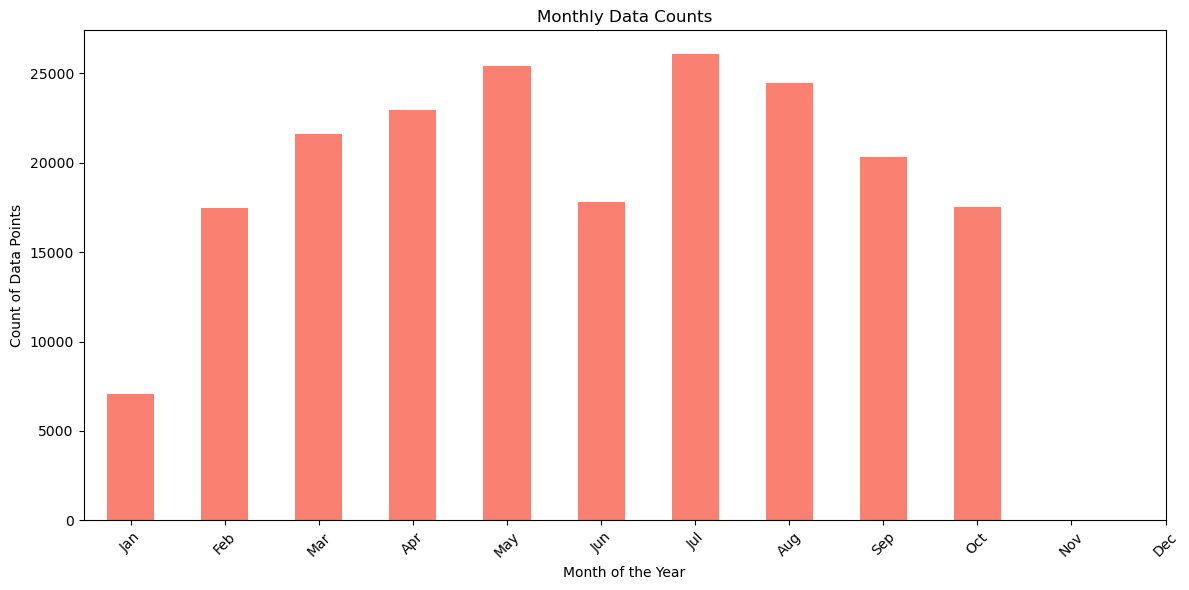

In [80]:
# Extract month from datetime
sunlab_minute['Solar_Month'] = sunlab_minute['Datetime'].dt.month

# group data by month for plotting
monthly_data_count = sunlab_minute.groupby('Solar_Month').size()

# Plot bar chart
plt.figure(figsize=(12,6))
monthly_data_count.plot(kind='bar', color='salmon')
plt.title('Monthly Data Counts')
plt.xlabel('Month of the Year')
plt.ylabel('Count of Data Points')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()

In [81]:
# Create hourly column
sunlab_minute['Hour'] = sunlab_minute['Datetime'].dt.floor('h')

In [82]:
sunlab_minute.head()

,Datetime,A_Vertical - Voltage DC [V],A_Vertical - Current DC [A],A_Vertical - Power DC [W],A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Horizontal - Voltage DC [V],A_Horizontal - Current DC [A],A_Horizontal - Power DC [W],...,Ambient Temperature [ÂºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Meteo_Month,Hour
0,2017-01-20 07:52:00+00:00,19.25,0.0750,1.44375,21.60,0.1075,2.322000,18.80,0.0650,1.222,...,4.900000,7.267174,6.914082,1.353073,3.600000,331.65972,0.0,1013.7668,1,2017-01-20 07:00:00+00:00
1,2017-01-20 07:53:00+00:00,19.25,0.0850,1.63625,32.15,0.0450,1.446750,18.80,0.0725,1.363,...,4.983333,8.119104,7.055244,1.416638,3.900000,330.66696,0.0,1013.7668,1,2017-01-20 07:00:00+00:00
2,2017-01-20 07:54:00+00:00,19.20,0.1175,2.25600,32.75,0.0450,1.473750,18.75,0.0800,1.500,...,5.000000,8.641460,8.173192,1.483865,3.550000,330.99438,0.0,1013.7834,1,2017-01-20 07:00:00+00:00
3,2017-01-20 07:55:00+00:00,19.30,0.2775,5.35575,32.95,0.1650,5.436750,18.75,0.1000,1.875,...,5.000000,9.611446,8.830058,1.548960,3.500000,330.83166,0.0,1013.8000,1,2017-01-20 07:00:00+00:00
4,2017-01-20 07:56:00+00:00,19.20,0.4900,9.40800,30.15,0.4375,13.190625,18.85,0.1200,2.262,...,5.000000,12.314148,10.599564,1.618800,4.316667,332.66656,0.0,1013.7834,1,2017-01-20 07:00:00+00:00


In [83]:
sunlab_minute.columns.tolist()

['Datetime',
 'A_Vertical - Voltage DC [V]',
 'A_Vertical - Current DC [A]',
 'A_Vertical - Power DC [W]',
 'A_Optimal - Voltage DC [V]',
 'A_Optimal - Current DC [A]',
 'A_Optimal - Power DC [W]',
 'A_Horizontal - Voltage DC [V]',
 'A_Horizontal - Current DC [A]',
 'A_Horizontal - Power DC [W]',
 'A_Vertical - Temperature [ÂºC]',
 'A_Optimal - Temperature [ÂºC]',
 'A_Horizontal - Temperature [ÂºC]',
 'B_Vertical - Voltage DC [V]',
 'B_Vertical - Current DC [A]',
 'B_Vertical - Power DC [W]',
 'B_Optimal - Voltage DC [V]',
 'B_Optimal - Current DC [A]',
 'B_Optimal - Power DC [W]',
 'B_Horizontal - Voltage DC [V]',
 'B_Horizontal - Current DC [A]',
 'B_Horizontal - Power DC [W]',
 'B_Vertical - Temperature [ÂºC]',
 'B_Optimal - Temperature [ÂºC]',
 'B_Horizontal - Temperature [ÂºC]',
 'Solar_Month',
 'Ambient Temperature [ÂºC]',
 'Global Radiation [W/m2]',
 'Diffuse Radiation [W/m2]',
 'Ultraviolet [W/m2]',
 'Wind Velocity [m/s]',
 'Wind Direction [Âº]',
 'Precipitation [mm]',
 'Atmosp

In [84]:
# aggregate data by hour
sunlab_hourly = sunlab_minute.groupby('Hour').agg({
    'A_Optimal - Power DC [W]': 'sum',
    'Ambient Temperature [ÂºC]': 'mean',
    'Ultraviolet [W/m2]': 'mean',
    'Wind Velocity [m/s]': 'mean',
    'Precipitation [mm]': 'sum'
}).reset_index()

# fields for 800K records file
# sunlab_hourly = sunlab_minute.groupby('Hour').agg({
    #'A_Optimal - Power DC [W]': 'sum',
    #'Ambient Temperature [C]': 'mean',
    #'Ultraviolet [W/m2]': 'mean',
    #'Wind Velocity [m/s]': 'mean',
    #'Precipitation [mm]': 'sum'
#}).reset_index()

sunlab_hourly.head()
    

,Hour,A_Optimal - Power DC [W],Ambient Temperature [ÂºC],Ultraviolet [W/m2],Wind Velocity [m/s],Precipitation [mm]
0,2017-01-20 07:00:00+00:00,70.772375,5.041667,1.592184,4.056250,0.0
1,2017-01-20 08:00:00+00:00,3660.636125,5.984167,5.102978,2.799444,0.0
2,2017-01-20 09:00:00+00:00,7623.869875,8.948870,13.629377,2.289548,0.0
3,2017-01-20 10:00:00+00:00,9757.190375,11.058056,21.854574,2.342500,0.0
4,2017-01-20 11:00:00+00:00,6705.836250,11.574723,22.511125,2.455278,0.0


In [85]:
sunlab_hourly.tail()

,Hour,A_Optimal - Power DC [W],Ambient Temperature [ÂºC],Ultraviolet [W/m2],Wind Velocity [m/s],Precipitation [mm]
3649,2017-12-31 13:00:00+00:00,8711.278500,17.848870,24.373180,3.041526,0.0
3650,2017-12-31 14:00:00+00:00,7638.875375,17.970556,21.371790,3.495556,0.0
3651,2017-12-31 15:00:00+00:00,3893.803375,17.797175,12.683717,3.807062,0.0
3652,2017-12-31 16:00:00+00:00,810.042250,17.177222,4.943903,3.613334,0.0
3653,2017-12-31 17:00:00+00:00,1.984500,16.800002,1.210529,4.691667,0.0


In [86]:
sunlab_hourly.describe()

,A_Optimal - Power DC [W],Ambient Temperature [ÂºC],Ultraviolet [W/m2],Wind Velocity [m/s],Precipitation [mm]
count,3654.000000,3.654000e+03,3654.000000,3.654000e+03,3654.000000
mean,5591.701570,-8.713091e+03,26.139081,-8.731640e+03,0.046894
std,4161.484651,5.279700e+05,19.574387,5.279699e+05,0.520137
min,0.918750,-3.191488e+07,0.505986,-3.191489e+07,0.000000
25%,1363.640500,1.671215e+01,8.747301,1.783469e+00,0.000000
50%,5555.963813,2.115153e+01,23.169148,2.568080e+00,0.000000
75%,9693.170375,2.573278e+01,41.735371,3.306204e+00,0.000000
max,13556.646000,3.698806e+01,67.202460,7.444722e+00,15.320000


In [62]:
# create file from hourly data
hourly_file = 'Hourly_Data.csv'
sunlab_hourly.to_csv(hourly_file, index=True)

In [87]:
# Create the target column
sunlab_hourly['Label'] = (sunlab_hourly['A_Optimal - Power DC [W]'].shift(-1) > sunlab_hourly['A_Optimal - Power DC [W]']).astype(int)

# Drop the last row since it cannot have a target
sunlab_hourly = sunlab_hourly[:-1]

In [88]:
# Set features and labels
X = sunlab_hourly.drop(columns=['Label', 'Hour'])
y = sunlab_hourly['Label']

# Split data to train, validation, test (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (2922, 5), (2922,)
Validation set: (365, 5), (365,)
Test set: (366, 5), (366,)


In [89]:
# Init Scaler
scaler = StandardScaler()

# Scale features
features_s = ['A_Optimal - Power DC [W]', 'Ambient Temperature [ÂºC]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Precipitation [mm]']

# 800K records file features
#features_s = ['A_Optimal - Power DC [W]', 'Ambient Temperature [C]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Precipitation [mm]']

# Fit scaler
X_train_scaled = scaler.fit_transform(X_train[features_s])

# Scale validation and test data
X_val_scaled = scaler.transform(X_val[features_s])
X_test_scaled = scaler.transform(X_test[features_s])

print(f"Train set (scaled): {X_train_scaled.shape}")
print(f"Validation set (scaled): {X_val_scaled.shape}")
print(f"Test set (scaled): {X_test_scaled.shape}")

Train set (scaled): (2922, 5)
Validation set (scaled): (365, 5)
Test set (scaled): (366, 5)


In [90]:
# Custom Dataset class
class PowerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = PowerDataset(X_train_scaled, y_train)
val_dataset = PowerDataset(X_val_scaled, y_val)
test_dataset = PowerDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2922
Validation dataset size: 365
Test dataset size: 366


In [91]:
# Create LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_num_layers, output_size=1):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, 
                            num_layers=lstm_num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        
    def forward(self, x):
        # Reshape input for CNN
        x = x.unsqueeze(1) 
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        # Take last time step's output
        lstm_out = lstm_out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(lstm_out)
        return torch.sigmoid(out)

In [92]:
# Define parameters
input_size = X_train_scaled.shape[1] 
lstm_hidden_size = 64 
lstm_num_layers = 2
output_size = 1  

# Initialize the LSTM model
model = LSTMModel(input_size, lstm_hidden_size, lstm_num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Init to store values
train_losses = []
val_losses = []

# Training parameters
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train() 
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Compute average training loss
    train_loss /= len(train_loader)
    # Store loss for plotting
    train_losses.append(train_loss)

    # Validation step
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Compute accuracy
            predicted = (outputs > 0.5).float() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    # Store for plotting
    val_losses.append(val_loss)
    accuracy = correct / total

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}")

Epoch [1/30], Train Loss: 0.6860, Val Loss: 0.6652, Val Acc: 0.6575
Epoch [2/30], Train Loss: 0.6022, Val Loss: 0.5385, Val Acc: 0.7836
Epoch [3/30], Train Loss: 0.5256, Val Loss: 0.5004, Val Acc: 0.7890
Epoch [4/30], Train Loss: 0.4912, Val Loss: 0.4843, Val Acc: 0.7918
Epoch [5/30], Train Loss: 0.4768, Val Loss: 0.4744, Val Acc: 0.7836
Epoch [6/30], Train Loss: 0.4730, Val Loss: 0.4740, Val Acc: 0.7836
Epoch [7/30], Train Loss: 0.4656, Val Loss: 0.4784, Val Acc: 0.7397
Epoch [8/30], Train Loss: 0.4693, Val Loss: 0.4643, Val Acc: 0.8027
Epoch [9/30], Train Loss: 0.4638, Val Loss: 0.4607, Val Acc: 0.7973
Epoch [10/30], Train Loss: 0.4646, Val Loss: 0.4605, Val Acc: 0.8055
Epoch [11/30], Train Loss: 0.4642, Val Loss: 0.4602, Val Acc: 0.7753
Epoch [12/30], Train Loss: 0.4638, Val Loss: 0.4594, Val Acc: 0.7973
Epoch [13/30], Train Loss: 0.4642, Val Loss: 0.4616, Val Acc: 0.8000
Epoch [14/30], Train Loss: 0.4666, Val Loss: 0.4772, Val Acc: 0.7370
Epoch [15/30], Train Loss: 0.4639, Val Loss

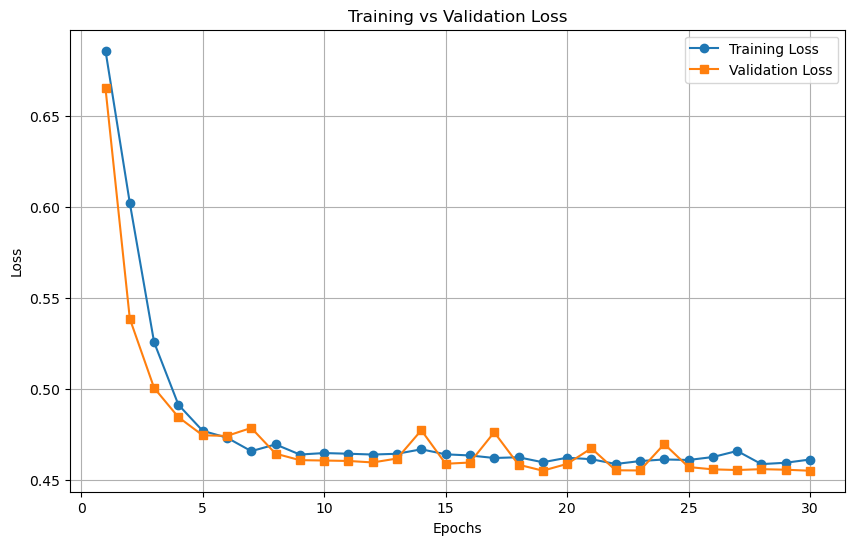

In [94]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [95]:
# Set model to evaluation mode
model.eval()

# Initialize test loss and predictions
test_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).float()

        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute average test loss
test_loss /= len(test_loader)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=1)
recall = recall_score(all_labels, all_preds, zero_division=1)
f1 = f1_score(all_labels, all_preds, zero_division=1)

# Print evaluation results
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Test Loss: 0.4179
Test Accuracy: 0.8169
Precision: 0.9291
Recall: 0.6705
F1-Score: 0.7789


In [96]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=["Power Decrease", "Power Increase"])

# Output report
print("Clasification Report")
print(report)

Clasification Report
                precision    recall  f1-score   support

Power Decrease       0.76      0.95      0.84       190
Power Increase       0.93      0.67      0.78       176

      accuracy                           0.82       366
     macro avg       0.84      0.81      0.81       366
  weighted avg       0.84      0.82      0.81       366



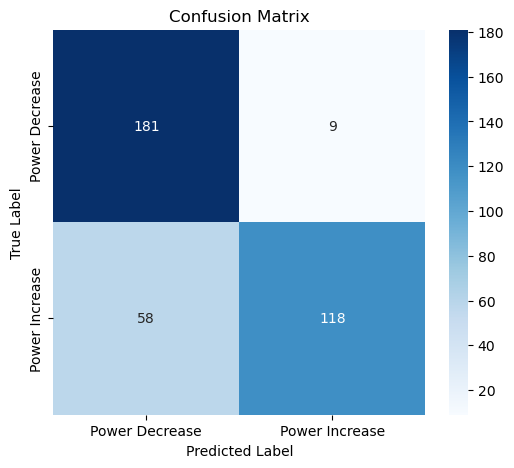

In [97]:
# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Power Decrease", "Power Increase"],
            yticklabels=["Power Decrease", "Power Increase"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()